# Experimental log 'Local Differential Private Estimation of Jaccard Similarity'

## Running the experiments

The code is provide in the subdirectory src of the main repo. The two files `exp_artificial.py` and `exp_real_world.py` provide the general experiment scripts. They are invoked from the bash scripts `run_artificial_exp.sh` and `run_real_world_exp.sh`. Run `make realworld` and `make artificial` to streamline the process of running experiments and compiling the measurements in csv files.

The raw experimental data that we measured in our work can be downloaded by invoking `get_raw_experimental_results.sh`. These files are necessary to run the following log.

In [12]:
import pandas as pd
from IPython.display import display
%matplotlib inline
import matplotlib
matplotlib.use('pgf')
import matplotlib.pyplot as plt
import seaborn as sns
import math

sns.set(rc={"xtick.bottom" : True, "ytick.left" : True})
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] =(20,10)
pd.options.display.max_rows = 2000
plt.rcParams['mathtext.fontset'] = 'cm'
#plt.rcParams['font.family'] = 'cmu serif'
plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'

sns.set_context('paper', font_scale=2)


# Helper functions

In [43]:
def add_mse_column(df):
    df['mse'] = df.apply(lambda row: (row.t - row.e)**2, axis = 1)

# MinHash / OneBit MinHash on Artificial Data

In [39]:
#df = pd.read_csv("minhash.csv")
df = pd.read_csv("onebit.csv")

In [44]:
add_mse_column(df)

In [45]:
plot_data = df[['D', 'K', 'mse', 'run']].groupby(["D", "K", 'run']).mean().reset_index()

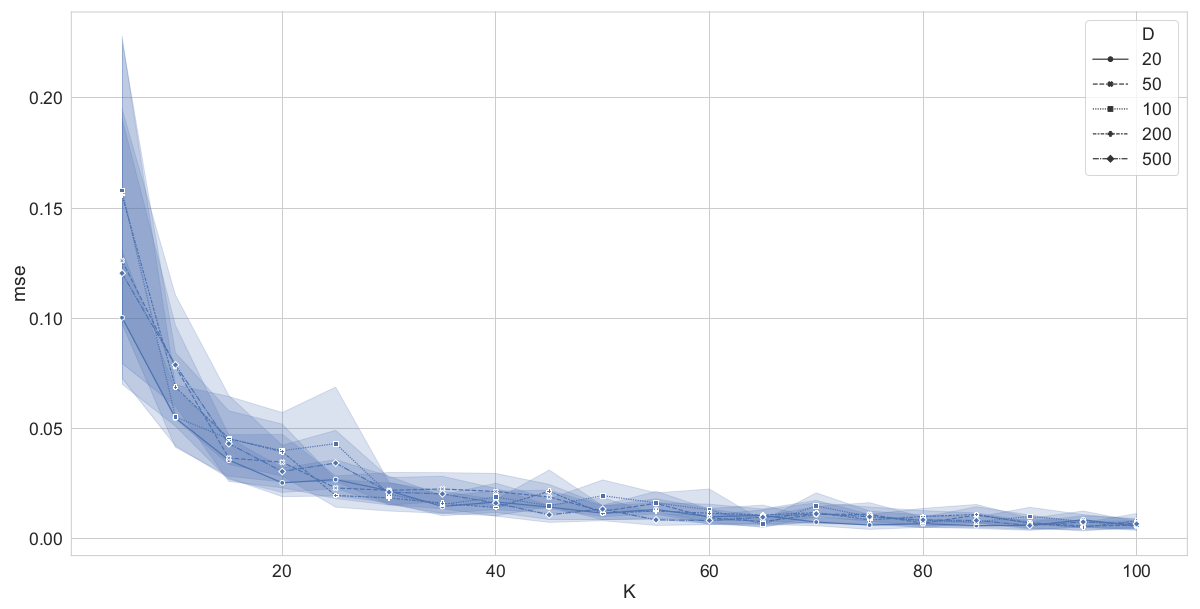

In [46]:
f, ax = plt.subplots()
#ax.set(yscale='log')
sns.lineplot(data=plot_data, ax=ax, x = "K", y = "mse", style = 'D', markers=True)

## Findings

1. The larger the K, the better. 
2. Starting from K around 10, MSE below 0.1 for all tested set sizes.

# Noisy MinHash on Artificial Data

In [47]:
df = pd.read_csv("noisy.csv")

In [48]:
add_mse_column(df)

In [49]:
df.head()

,date,D,K,t,e,scale,run,mse
0,2019-06-18 22:03:32.074105,100,5,0.000000,-0.2,0.0,0,0.040000
1,2019-06-18 22:03:32.074508,100,5,0.052632,0.2,0.0,0,0.021717
2,2019-06-18 22:03:32.074912,100,5,0.104972,0.2,0.0,0,0.009030
3,2019-06-18 22:03:32.075307,100,5,0.156069,0.2,0.0,0,0.001930
4,2019-06-18 22:03:32.075696,100,5,0.204819,0.2,0.0,0,0.000023


In [50]:
noisy_df = df[['scale', 'D', 'K', 'mse', 'run']].groupby(['scale', "D", "K", 'run']).mean().reset_index()

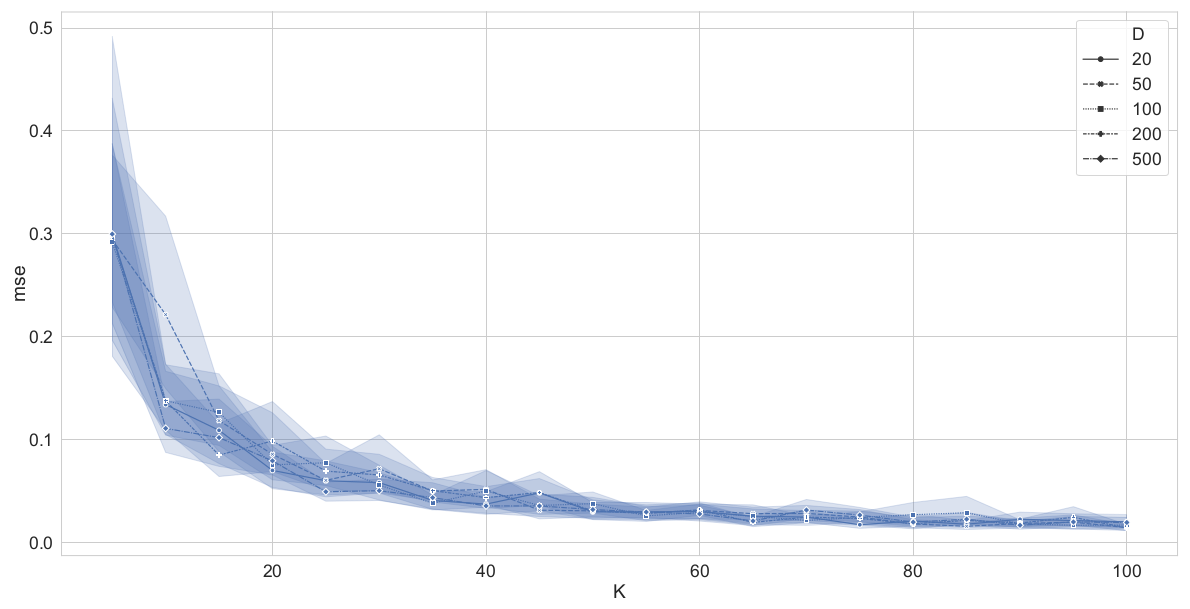

In [52]:
#  Check individiual scale

scale = 0.2
f, ax = plt.subplots()
#ax.set(yscale='log')
sns.lineplot(data=noisy_df[noisy_df.scale == scale ], ax=ax, x = "K", y = "mse", style = 'D', markers=True)

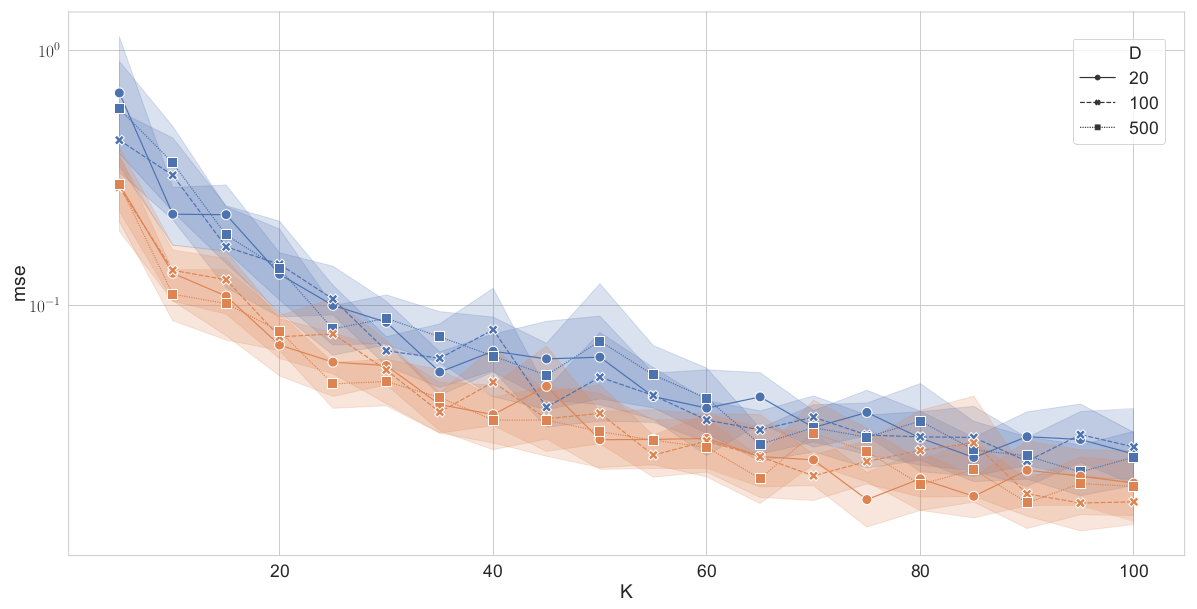

In [53]:
# Compare 0.2 and 0.25 on selection of set sizes
# Figure used in paper

f, ax = plt.subplots()
ax.set(yscale='log')
sns.lineplot(data=noisy_df[(noisy_df.scale == 0.25) & ((noisy_df.D == 20) | (noisy_df.D == 100) | (noisy_df.D == 500) ) ], ax=ax,x = "K", y = "mse", style = 'D', markers=True,ms=10)
sns.lineplot(data=noisy_df[(noisy_df.scale == 0.2) & ((noisy_df.D == 20) | (noisy_df.D == 100) | (noisy_df.D == 500) ) ], ax=ax, x = "K", y = "mse", style = 'D', markers=True,ms=10)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:4], labels[0:4], bbox_to_anchor=(0.9, .95), loc=2, borderaxespad=0.)


In [54]:
# collapse 
collapsed_noisy_df = noisy_df[['scale','D','K','mse']].groupby(['scale', 'D', 'K']).mean().reset_index()

Let us compute the (epsilon, delta) values achieved by these runs. We fix a delta value and compute the epsilon value according as Delta / scale according to the Delta in the paper.

In [55]:
# compute achieved epsilon values

for delta in [0.01, 0.001, 0.0001]:
    collapsed_noisy_df['alpha=1,delta=' + str(delta)] = collapsed_noisy_df.apply(lambda row: 1/row.scale * (1/row.D * row.K / 2 + math.sqrt(3 * math.log(1/delta) * 1 / row.D * row.K / 2)), axis = 1)
    
for f in [.1, .5]:
    for delta in [0.01, 0.001, 0.0001]:
        collapsed_noisy_df['alpha=' + str(f) + ',delta=' + str(delta)] = collapsed_noisy_df.apply(lambda row: 1/row.scale * (f * row.K / 2 + math.sqrt(3 * math.log(1/delta) * f * row.K / 2)), axis = 1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  


In [57]:
# show the achieved epsilon values
collapsed_noisy_df[(collapsed_noisy_df.scale > 0.0) & (collapsed_noisy_df.scale <= 0.3) & (collapsed_noisy_df.mse < 0.1)].sort_values(by='alpha=0.5,delta=0.01')

,scale,D,K,mse,"alpha=1,delta=0.01","alpha=1,delta=0.001","alpha=1,delta=0.0001","alpha=0.1,delta=0.01","alpha=0.1,delta=0.001","alpha=0.1,delta=0.0001","alpha=0.5,delta=0.01","alpha=0.5,delta=0.001","alpha=0.5,delta=0.0001"
462,0.20,200,15,0.085055,3.786394,4.595228,5.277105,19.844745,23.461957,26.511407,54.738944,62.827275,69.646053
321,0.15,50,10,0.095875,8.502627,10.263718,11.748388,20.855073,24.792994,28.112815,55.846467,64.651926,72.075271
381,0.15,500,10,0.092802,2.544615,3.101521,3.571015,20.855073,24.792994,28.112815,55.846467,64.651926,72.075271
301,0.15,20,10,0.090878,14.056407,16.840938,19.188406,20.855073,24.792994,28.112815,55.846467,64.651926,72.075271
584,0.25,500,25,0.081135,2.450788,2.979116,3.424516,21.622581,25.358421,28.507880,62.169222,70.522814,77.565218
403,0.20,20,20,0.070139,15.641304,18.594745,21.084611,23.584611,27.761407,31.282609,66.556453,75.896053,83.769700
463,0.20,200,20,0.098757,4.405645,5.339605,6.126970,23.584611,27.761407,31.282609,66.556453,75.896053,83.769700
483,0.20,500,20,0.079483,2.728261,3.318949,3.816922,23.584611,27.761407,31.282609,66.556453,75.896053,83.769700
423,0.20,50,20,0.085843,9.311291,11.179211,12.753940,23.584611,27.761407,31.282609,66.556453,75.896053,83.769700
443,0.20,100,20,0.075552,6.376970,7.697789,8.811291,23.584611,27.761407,31.282609,66.556453,75.896053,83.769700


In [59]:
collapsed_noisy_df[(collapsed_noisy_df.D == 500) & (collapsed_noisy_df.mse < 0.1)].sort_values(by='alpha=1,delta=0.01')

,scale,D,K,mse,"alpha=1,delta=0.01","alpha=1,delta=0.001","alpha=1,delta=0.0001","alpha=0.1,delta=0.01","alpha=0.1,delta=0.001","alpha=0.1,delta=0.0001","alpha=0.5,delta=0.01","alpha=0.5,delta=0.001","alpha=0.5,delta=0.0001"
584,0.25,500,25,0.081135,2.450788,2.979116,3.424516,21.622581,25.358421,28.507880,62.169222,70.522814,77.565218
381,0.15,500,10,0.092802,2.544615,3.101521,3.571015,20.855073,24.792994,28.112815,55.846467,64.651926,72.075271
585,0.25,500,30,0.089324,2.695159,3.273913,3.761825,24.209126,28.301533,31.751592,70.716843,79.867744,87.582311
483,0.20,500,20,0.079483,2.728261,3.318949,3.816922,23.584611,27.761407,31.282609,66.556453,75.896053,83.769700
586,0.25,500,35,0.075573,2.921490,3.546615,4.073621,26.668104,31.088409,34.814899,78.979216,88.863320,97.196004
484,0.20,500,25,0.049424,3.063485,3.723894,4.280645,27.028227,31.698027,35.634850,77.711527,88.153517,96.956522
587,0.25,500,40,0.063534,3.133538,3.801825,4.365217,29.026087,33.751592,37.735378,87.015760,97.582311,106.490325
382,0.15,500,15,0.079488,3.134854,3.816922,4.391932,26.459660,31.282609,35.348543,72.985259,83.769700,92.861404
588,0.25,500,45,0.053415,3.333913,4.042739,4.640307,31.301533,36.313688,40.539131,94.867744,106.075264,115.523640
485,0.20,500,30,0.050463,3.368949,4.092391,4.702281,30.261407,35.376916,39.689490,88.396053,99.834680,109.477889


## Findings

1. Noise <= .3 allows for good recovery of original distance.
2. K around 30 gives best value (recovery possible, pretty small epsilon)
3. Can get Eps around 2-3 for large sets
4. Can get Eps around 10 for small sets
5. Small influence of delta. Usually ranges in small additive summand to get from .01 to 0.0001.

# BucketMinHash on Artificial Data

In [60]:
bucket_df = pd.read_csv("bucket.csv")

In [61]:
add_mse_column(bucket_df)
# also compute the 'true eps', which is K * individual eps
bucket_df['actual_eps'] = bucket_df.apply(lambda row: (row.eps * row.K), axis = 1)

In [62]:
bucket_df.head()

,date,D,K,t,e,bf,buckets,sparsity,eps,run,mse,actual_eps
0,2019-06-18 22:03:34.551925,100,5,0.000000,-0.083956,0.05,101,1.0,4,0,0.007049,20
1,2019-06-18 22:03:34.552491,100,5,0.052632,-0.083956,0.05,101,1.0,4,0,0.018656,20
2,2019-06-18 22:03:34.553046,100,5,0.104972,-0.083956,0.05,101,1.0,4,0,0.035694,20
3,2019-06-18 22:03:34.553628,100,5,0.156069,-0.083956,0.05,101,1.0,4,0,0.057612,20
4,2019-06-18 22:03:34.554176,100,5,0.204819,-0.083956,0.05,101,1.0,4,0,0.083391,20


In [63]:
plot_data = bucket_df[['D', 'K', 'mse', 'bf', 'sparsity', 'eps', 'actual_eps']].groupby(['D', 'K', 'bf', 'sparsity', 'actual_eps']).mean().reset_index()

In [64]:
# check which eps values can be achieved for m = 2\tau.
plot_data[(plot_data.D == 20) & (plot_data.mse < 0.1) & (plot_data.sparsity == 1.0)].sort_values(by='actual_eps')

,D,K,bf,sparsity,actual_eps,mse,eps
36,20,5,0.1,1.0,30,0.052499,6
246,20,5,1.0,1.0,30,0.065988,6
71,20,5,0.2,1.0,30,0.042087,6
211,20,5,0.9,1.0,30,0.048698,6
176,20,5,0.8,1.0,30,0.053035,6
141,20,5,0.6,1.0,30,0.061972,6
106,20,5,0.4,1.0,30,0.052931,6
385,20,10,0.4,1.0,40,0.059792,4
350,20,10,0.2,1.0,40,0.045852,4
315,20,10,0.1,1.0,40,0.053072,4


In [314]:
# check with eps values can be achieved for m = 100\tau.
plot_data[(plot_data.D == 20) & (plot_data.mse < 0.1) & (plot_data.sparsity == 50.0)].sort_values(by='actual_eps')

,D,K,bf,sparsity,actual_eps,mse,eps
30,20,5,0.05,50.0,40,0.032451,8
65,20,5,0.10,50.0,40,0.051917,8
100,20,5,0.20,50.0,40,0.060328,8
241,20,5,0.90,50.0,50,0.059898,10
206,20,5,0.80,50.0,50,0.077106,10
171,20,5,0.60,50.0,50,0.060606,10
136,20,5,0.40,50.0,50,0.036759,10
101,20,5,0.20,50.0,50,0.033954,10
276,20,5,1.00,50.0,50,0.049372,10
66,20,5,0.10,50.0,50,0.030216,10


In [65]:
# check which eps values can be achieved for tau = 500 and m = 1000.
plot_data[(plot_data.D == 500) & (plot_data.sparsity == 1.0) & (plot_data.eps > 4)].sort_values(by=['K', 'mse'])

,D,K,bf,sparsity,actual_eps,mse,eps
9840,500,5,0.10,1.0,70,0.022243,14
9911,500,5,0.40,1.0,80,0.023005,16
9804,500,5,0.05,1.0,60,0.023890,12
9806,500,5,0.05,1.0,80,0.025517,16
9980,500,5,0.80,1.0,70,0.026621,14
10016,500,5,0.90,1.0,80,0.027656,16
9944,500,5,0.60,1.0,60,0.028410,12
9979,500,5,0.80,1.0,60,0.029429,12
9873,500,5,0.20,1.0,50,0.029892,10
9909,500,5,0.40,1.0,60,0.030460,12


In [316]:
plot_data[(plot_data.D == 500) & (plot_data.sparsity == 50.0) & (plot_data.K < 20) & (plot_data.eps >= 8)].sort_values(by='bf')

,D,K,bf,sparsity,actual_eps,mse,eps
9830,500,5,0.05,50.0,40,0.231953,8
10394,500,15,0.05,50.0,240,0.011546,16
10393,500,15,0.05,50.0,210,0.011797,14
10392,500,15,0.05,50.0,180,0.011740,12
10391,500,15,0.05,50.0,150,0.014596,10
10390,500,15,0.05,50.0,120,0.083321,8
10110,500,10,0.05,50.0,80,0.109786,8
10111,500,10,0.05,50.0,100,0.023058,10
10112,500,10,0.05,50.0,120,0.015150,12
10114,500,10,0.05,50.0,160,0.011548,16


In [66]:
plot_data_runs = bucket_df[['D', 'K', 'mse', 'bf', 'buckets', 'sparsity', 'eps', 'actual_eps', 'run']].groupby(['D', 'K', 'buckets', 'bf', 'sparsity', 'actual_eps', 'run']).mean().reset_index()

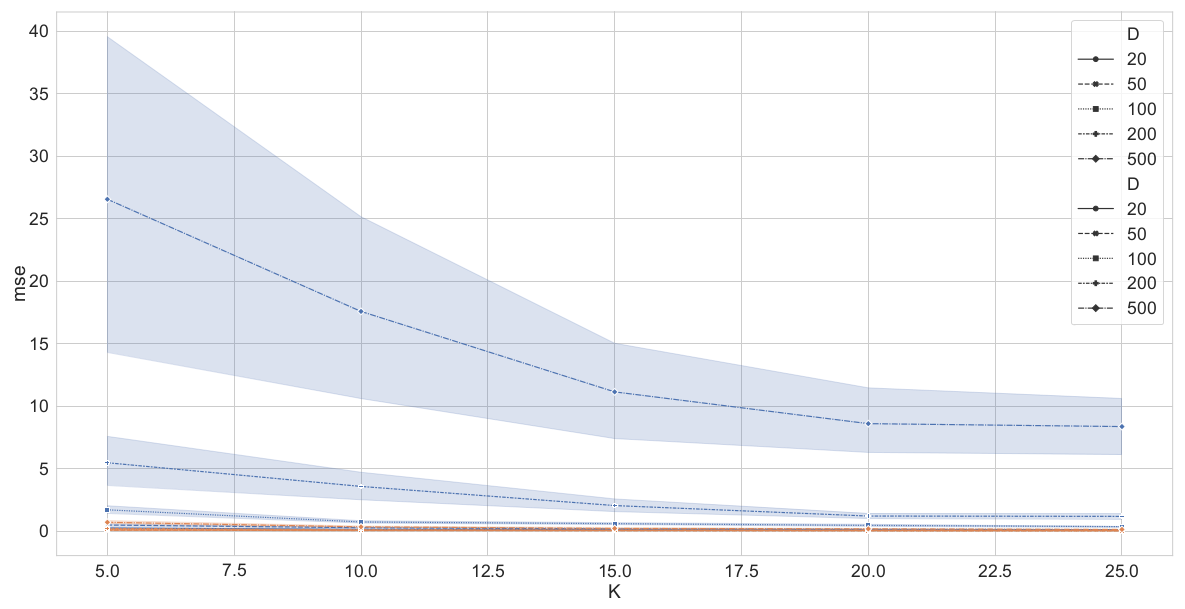

In [69]:

sns.lineplot(data=plot_data_runs[(plot_data_runs.eps == 4) & (plot_data_runs.sparsity == 1.0) & (plot_data_runs.K <= 25)], x = "K", y = "mse", style = 'D', markers=True)
sns.lineplot(data=plot_data_runs[(plot_data_runs.eps == 6) & (plot_data_runs.sparsity == 1.0) & (plot_data_runs.K <= 25)], x = "K", y = "mse", style = 'D', markers=True)

Individual eps of 4 gives to high estimation error. Note that this averages over all bucket sizes. Let's look at small/large number of buckets:

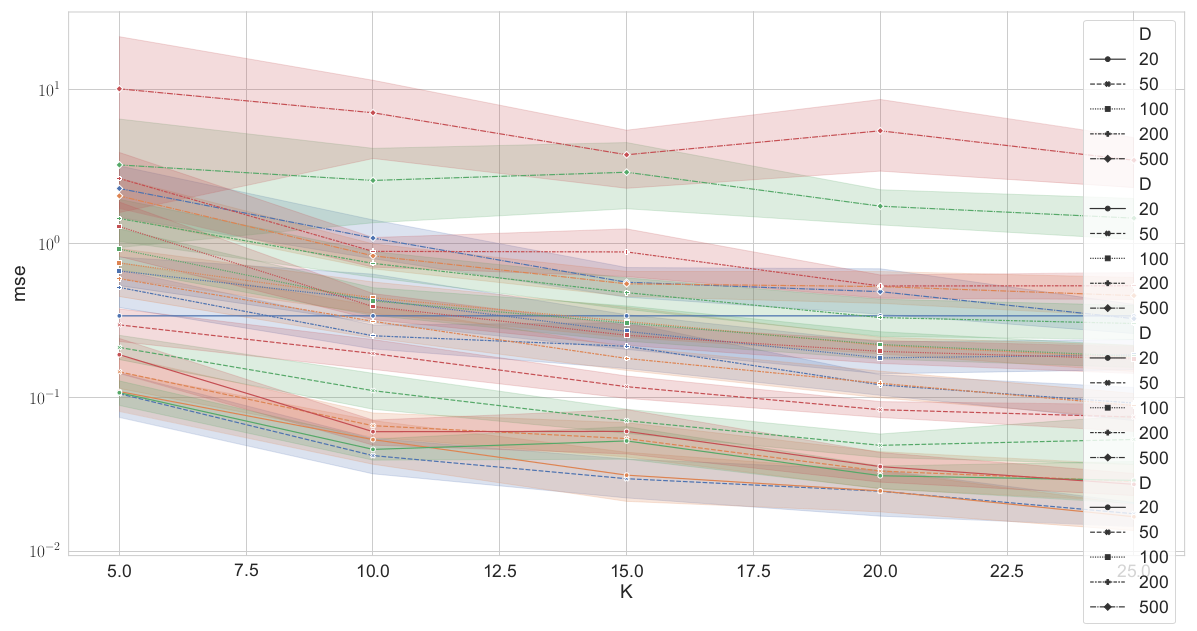

In [80]:
f, ax = plt.subplots()
ax.set(yscale='log')
sns.lineplot(ax=ax,data=plot_data_runs[(plot_data_runs.eps == 4) & (plot_data_runs.sparsity == 1.0) & (plot_data_runs.K <= 25) & (plot_data_runs.bf == 0.05)], x = "K", y = "mse", style = 'D', markers=True)
sns.lineplot(ax=ax,data=plot_data_runs[(plot_data_runs.eps == 4) & (plot_data_runs.sparsity == 1.0) & (plot_data_runs.K <= 25) & (plot_data_runs.bf == 0.1)], x = "K", y = "mse", style = 'D', markers=True)
sns.lineplot(ax=ax,data=plot_data_runs[(plot_data_runs.eps == 4) & (plot_data_runs.sparsity == 1.0) & (plot_data_runs.K <= 25) & (plot_data_runs.bf == 0.2)], x = "K", y = "mse", style = 'D', markers=True)
sns.lineplot(ax=ax,data=plot_data_runs[(plot_data_runs.eps == 4) & (plot_data_runs.sparsity == 1.0) & (plot_data_runs.K <= 25) & (plot_data_runs.bf == 0.4)], x = "K", y = "mse", style = 'D', markers=True)


#sns.lineplot(data=plot_data_runs[(plot_data_runs.eps == 6) & (plot_data_runs.sparsity == 1.0) & (plot_data_runs.K <= 25) & (plot_data_runs.bf == 0.4)], x = "K", y = "mse", style = 'D', markers=True)

Smaller buckets are better for eps = 4. Starting from K = 10, smallest choice gives MSE < 0.1

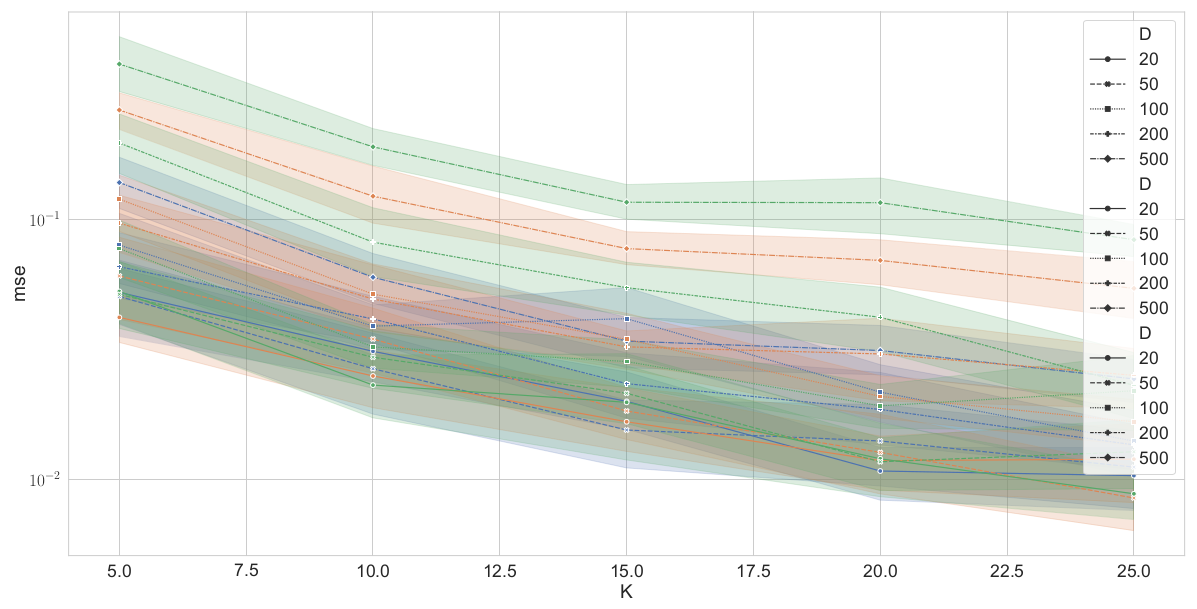

In [82]:
f, ax = plt.subplots()
ax.set(yscale='log')
#sns.lineplot(ax=ax,data=plot_data_runs[(plot_data_runs.eps == 6) & (plot_data_runs.sparsity == 1.0) & (plot_data_runs.K <= 25) & (plot_data_runs.bf == 0.05)], x = "K", y = "mse", style = 'D', markers=True)
sns.lineplot(ax=ax,data=plot_data_runs[(plot_data_runs.eps == 6) & (plot_data_runs.sparsity == 1.0) & (plot_data_runs.K <= 25) & (plot_data_runs.bf == 0.1)], x = "K", y = "mse", style = 'D', markers=True)
sns.lineplot(ax=ax,data=plot_data_runs[(plot_data_runs.eps == 6) & (plot_data_runs.sparsity == 1.0) & (plot_data_runs.K <= 25) & (plot_data_runs.bf == 0.2)], x = "K", y = "mse", style = 'D', markers=True)
sns.lineplot(ax=ax,data=plot_data_runs[(plot_data_runs.eps == 6) & (plot_data_runs.sparsity == 1.0) & (plot_data_runs.K <= 25) & (plot_data_runs.bf == 0.4)], x = "K", y = "mse", style = 'D', markers=True)


#sns.lineplot(data=plot_data_runs[(plot_data_runs.eps == 6) & (plot_data_runs.sparsity == 1.0) & (plot_data_runs.K <= 25) & (plot_data_runs.bf == 0.4)], x = "K", y = "mse", style = 'D', markers=True)

Again, smaller buckets are better. MSE < 0.1 can be achieved for K = 5, except for 500 elements. (Maybe still too many buckets?)

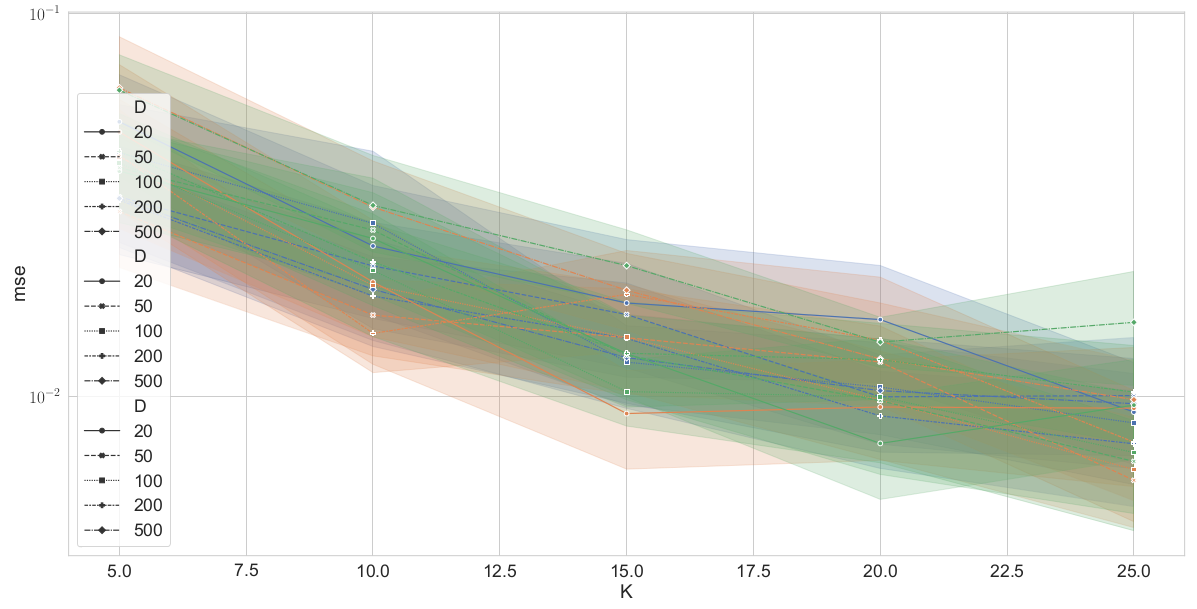

In [79]:
f, ax = plt.subplots()
ax.set(yscale='log')
sns.lineplot(ax=ax,data=plot_data_runs[(plot_data_runs.eps == 8) & (plot_data_runs.sparsity == 1.0) & (plot_data_runs.K <= 25) & (plot_data_runs.bf == 0.1)], x = "K", y = "mse", style = 'D', markers=True)
sns.lineplot(ax=ax,data=plot_data_runs[(plot_data_runs.eps == 8) & (plot_data_runs.sparsity == 1.0) & (plot_data_runs.K <= 25) & (plot_data_runs.bf == 0.2)], x = "K", y = "mse", style = 'D', markers=True)
sns.lineplot(ax=ax,data=plot_data_runs[(plot_data_runs.eps == 8) & (plot_data_runs.sparsity == 1.0) & (plot_data_runs.K <= 25) & (plot_data_runs.bf == 0.4)], x = "K", y = "mse", style = 'D', markers=True)


#sns.lineplot(data=plot_data_runs[(plot_data_runs.eps == 6) & (plot_data_runs.sparsity == 1.0) & (plot_data_runs.K <= 25) & (plot_data_runs.bf == 0.4)], x = "K", y = "mse", style = 'D', markers=True)

Good MSE for all bucket sizes for eps = 8.

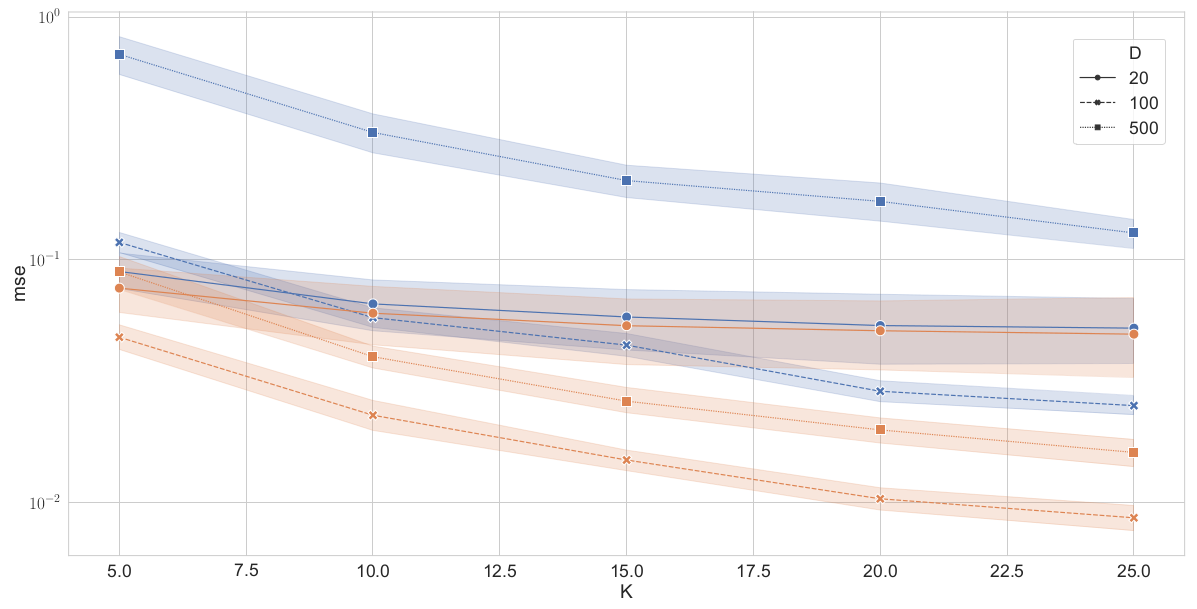

In [83]:
# Plot used in the paper.
f, ax = plt.subplots()
ax.set(yscale='log')
sns.lineplot(data=plot_data_runs[(plot_data_runs.eps == 6) & (plot_data_runs.sparsity == 1.0) & (plot_data_runs.K <= 25) & ((plot_data_runs.D == 20) | (plot_data_runs.D == 100) | (plot_data_runs.D == 500))], ax=ax, x = "K", y = "mse", style = 'D', markers=True,ms=10)
sns.lineplot(data=plot_data_runs[(plot_data_runs.eps == 8) & (plot_data_runs.sparsity == 1.0) & (plot_data_runs.K <= 25) & ((plot_data_runs.D == 20) | (plot_data_runs.D == 100) | (plot_data_runs.D == 500))], ax=ax,x = "K", y = "mse",  style = 'D', markers=True,ms=10)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:4], labels[0:4], bbox_to_anchor=(0.9, .95), loc=2, borderaxespad=0.)

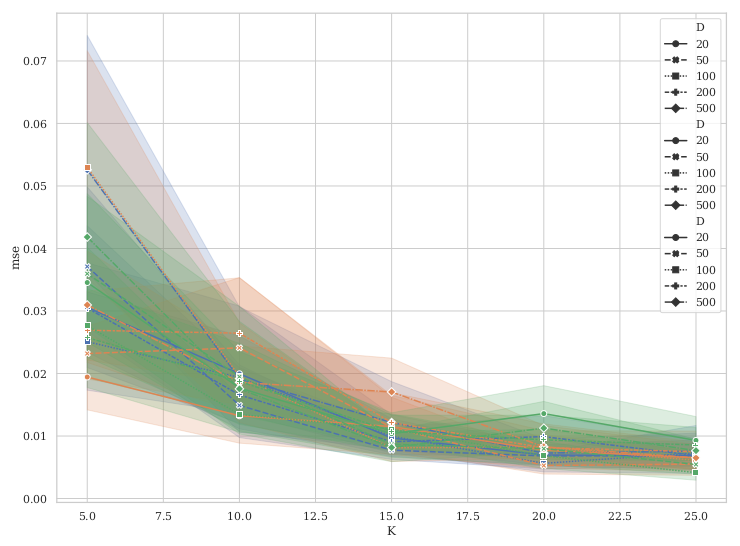

In [377]:
sns.lineplot(data=plot_data_runs[(plot_data_runs.eps == 16) & (plot_data_runs.sparsity == 50.0) & (plot_data_runs.K <= 25) & (plot_data_runs.bf == 0.1)], x = "K", y = "mse", style = 'D', markers=True)
sns.lineplot(data=plot_data_runs[(plot_data_runs.eps == 16) & (plot_data_runs.sparsity == 50.0) & (plot_data_runs.K <= 25) & (plot_data_runs.bf == 0.4)], x = "K", y = "mse", style = 'D', markers=True)
sns.lineplot(data=plot_data_runs[(plot_data_runs.eps == 16) & (plot_data_runs.sparsity == 50.0) & (plot_data_runs.K <= 25) & (plot_data_runs.bf == 0.8)], x = "K", y = "mse", style = 'D', markers=True)


In [85]:
plot_data_runs[(plot_data_runs.eps == 8) & (plot_data_runs.sparsity == 1.0) & (plot_data_runs.K <= 25) & (plot_data_runs.bf == 0.1)]

,D,K,buckets,bf,sparsity,actual_eps,run,mse,eps
320,20,5,6,0.1,1.0,40,0,0.057586,8
321,20,5,6,0.1,1.0,40,1,0.035858,8
322,20,5,6,0.1,1.0,40,2,0.017931,8
323,20,5,6,0.1,1.0,40,3,0.021175,8
324,20,5,6,0.1,1.0,40,4,0.047364,8
325,20,5,6,0.1,1.0,40,5,0.036385,8
326,20,5,6,0.1,1.0,40,6,0.030717,8
327,20,5,6,0.1,1.0,40,7,0.128950,8
328,20,5,6,0.1,1.0,40,8,0.044695,8
329,20,5,6,0.1,1.0,40,9,0.077758,8


In [86]:

plot_data_runs[(plot_data_runs.eps == 8) & (plot_data_runs.sparsity == 1.0) & (plot_data_runs.K <= 25) & (plot_data_runs.bf == 0.4)]

,D,K,buckets,bf,sparsity,actual_eps,run,mse,eps
1300,20,5,21,0.4,1.0,40,0,0.021319,8
1301,20,5,21,0.4,1.0,40,1,0.010911,8
1302,20,5,21,0.4,1.0,40,2,0.032748,8
1303,20,5,21,0.4,1.0,40,3,0.013445,8
1304,20,5,21,0.4,1.0,40,4,0.083324,8
1305,20,5,21,0.4,1.0,40,5,0.015022,8
1306,20,5,21,0.4,1.0,40,6,0.082062,8
1307,20,5,21,0.4,1.0,40,7,0.052163,8
1308,20,5,21,0.4,1.0,40,8,0.035272,8
1309,20,5,21,0.4,1.0,40,9,0.051474,8


## Findings

- Sparsity = 1: Can obtain eps ~ 20-40 and SME < 0.1. Rather small number of K needed, rather large individual eps (>= 8).
- Sparsity = 50: Still works well, but fewer combinations. Usually doubles the eps value needed.
- Number of buckets: 10% of universe size.
- Worse eps than the noisy minhash, but much stronger privacy guarantees.

# Experiments on Real World datasets

## LastFM

In [87]:
lastfm_noisy = pd.read_csv("lastfm_noisy_selection.csv")

In [88]:
lastfm_noisy.head()

,method,date,dataset,k,t,e,scale,run
0,noisy,2019-06-20 12:56:20.895046,lastfm,10,1.0,1.0,0.0,0
1,noisy,2019-06-20 12:56:20.895231,lastfm,10,1.0,1.0,0.0,0
2,noisy,2019-06-20 12:56:20.895271,lastfm,10,1.0,1.0,0.0,0
3,noisy,2019-06-20 12:56:20.895308,lastfm,10,1.0,1.0,0.0,0
4,noisy,2019-06-20 12:56:20.895342,lastfm,10,1.0,1.0,0.0,0


In [89]:
add_mse_column(lastfm_noisy)

In [90]:
lastfm_noisy.head()

,method,date,dataset,k,t,e,scale,run,mse
0,noisy,2019-06-20 12:56:20.895046,lastfm,10,1.0,1.0,0.0,0,0.0
1,noisy,2019-06-20 12:56:20.895231,lastfm,10,1.0,1.0,0.0,0,0.0
2,noisy,2019-06-20 12:56:20.895271,lastfm,10,1.0,1.0,0.0,0,0.0
3,noisy,2019-06-20 12:56:20.895308,lastfm,10,1.0,1.0,0.0,0,0.0
4,noisy,2019-06-20 12:56:20.895342,lastfm,10,1.0,1.0,0.0,0,0.0


In [91]:
plot_df = lastfm_noisy[['k', 'mse', 'scale', 'run']].groupby(['k', 'scale', 'run']).mean().reset_index()

In [93]:
plot_df.groupby(['k', 'scale']).mean()

run       mse
k  scale               
10 0.00     2  0.087160
   0.05     2  0.094901
   0.10     2  0.119019
   0.15     2  0.144348
   0.20     2  0.222842
   0.25     2  0.326988
   0.30     2  0.502659
   0.35     2  0.712125
25 0.00     2  0.034970
   0.05     2  0.037582
   0.10     2  0.046114
   0.15     2  0.061453
   0.20     2  0.091062
   0.25     2  0.138504
   0.30     2  0.211503
   0.35     2  0.314354
40 0.00     2  0.022406
   0.05     2  0.023451
   0.10     2  0.029932
   0.15     2  0.039639
   0.20     2  0.061244
   0.25     2  0.091481
   0.30     2  0.138937
   0.35     2  0.207675
60 0.00     2  0.015378
   0.05     2  0.015764
   0.10     2  0.019844
   0.15     2  0.026268
   0.20     2  0.040565
   0.25     2  0.065163
   0.30     2  0.099448
   0.35     2  0.161803

### Findings

- need rather large K (25-40) to get good estimation
- .2 noise upper limit for K = 25, .25 ok for K = 40.

## Bucket

In [95]:
lastfm_bucket = pd.read_csv("lastfm_bucket.csv")

In [96]:
add_mse_column(lastfm_bucket)

In [97]:
lastfm_bucket[['bf', 'k', 'buckets', 'eps', 'mse']].groupby(['k','bf','buckets','eps']).mean()

mse
k  bf     buckets eps               
5  0.0001 1       4         0.108151
                  6         0.108151
                  8         0.108151
                  12        0.108151
   0.0003 7       4         0.089458
                  6         0.060975
                  8         0.055335
                  12        0.059577
   0.0010 2677    4    313013.959276
                  6       156.064856
                  8         0.468352
                  12        0.041739
10 0.0001 1       4         0.108151
                  6         0.108151
                  8         0.108151
                  12        0.108151
   0.0003 7       4         0.047026
                  6         0.027085
                  8         0.031557
                  12        0.028600
   0.0010 2677    4    312770.118391
                  6       154.948182
                  8         0.388692
                  12        0.016901
15 0.0001 1       4         0.108151
                  6         0.108151
                  8         0.108151
                  12        0.108151
   0.0003 7       4         0.031508
                  6         0.019465
                  8         0.022932
                  12        0.019935
   0.0010 2677    4    312645.087803
                  6       154.737725
                  8         0.368406
                  12        0.011228
20 0.0001 1       4         0.108151
                  6         0.108151
                  8         0.108151
                  12        0.108151
   0.0003 7       4         0.026244
                  6         0.015332
                  8         0.017991
                  12        0.014769
   0.0010 2677    4    312595.183378
                  6       154.276429
                  8         0.352922
                  12        0.009089

In [103]:
lastfm_bucket_eps = lastfm_bucket[['bf', 'k', 'buckets', 'eps', 'mse']].groupby(['k','bf','buckets','eps']).mean().reset_index()

In [104]:
lastfm_bucket_eps['actual_eps'] = lastfm_bucket_eps.apply(lambda row: (row.eps * row.k), axis = 1)

In [105]:
lastfm_bucket_eps[lastfm_bucket_eps.mse < 0.1].sort_values(by='actual_eps')

,k,bf,buckets,eps,mse,actual_eps
4,5,0.0003,7,4,0.089458,20.0
5,5,0.0003,7,6,0.060975,30.0
6,5,0.0003,7,8,0.055335,40.0
16,10,0.0003,7,4,0.047026,40.0
7,5,0.0003,7,12,0.059577,60.0
11,5,0.0010,2677,12,0.041739,60.0
17,10,0.0003,7,6,0.027085,60.0
28,15,0.0003,7,4,0.031508,60.0
18,10,0.0003,7,8,0.031557,80.0
40,20,0.0003,7,4,0.026244,80.0


### Findings 
7 buckets work already well, eps = 4 gives good enough accuracy.

## Movielens

## Noisy

In [106]:
ml_noisy = pd.read_csv("movielens_noisy_selection.csv")

In [107]:
add_mse_column(ml_noisy)

In [108]:
ml_noisy.head()

,method,date,dataset,k,t,e,scale,run,mse
0,noisy,2019-06-20 10:06:55.102865,movielens,5,1.000000,1.0,0.0,0,0.000000
1,noisy,2019-06-20 10:06:55.102970,movielens,5,1.000000,1.0,0.0,0,0.000000
2,noisy,2019-06-20 10:06:55.103036,movielens,5,0.204861,0.2,0.0,0,0.000024
3,noisy,2019-06-20 10:06:55.103082,movielens,5,0.222930,-0.2,0.0,0,0.178870
4,noisy,2019-06-20 10:06:55.103138,movielens,5,0.227848,0.2,0.0,0,0.000776


In [109]:
ml_noisy[['k', 'scale','mse']].groupby(['k', 'scale']).mean()

mse
k  scale          
5  0.00   0.174858
   0.05   0.196328
   0.10   0.231305
   0.15   0.322167
   0.20   0.453286
   0.25   0.719664
   0.30   1.028353
   0.35   1.484725
25 0.00   0.036847
   0.05   0.038845
   0.10   0.049285
   0.15   0.066441
   0.20   0.092520
   0.25   0.135059
   0.30   0.215451
   0.35   0.334091
40 0.00   0.022118
   0.05   0.024127
   0.10   0.029084
   0.15   0.039423
   0.20   0.058978
   0.25   0.091573
   0.30   0.145534
   0.35   0.216779

Analogous behavior to Last.FM dataset.

In [110]:
ml_eps_discussion = ml_noisy[['k', 'scale','mse']].groupby(['k', 'scale']).mean().reset_index()

In [111]:
for delta in [0.01, 0.001, 0.0001, 0.00001]:
    ml_eps_discussion['alpha=1,delta=' + str(delta)] = ml_eps_discussion.apply(lambda row: 1/row.scale * (1/178 * row.k / 2 + math.sqrt(3 * math.log(1/delta) * 1 / 178 * row.k / 2)), axis = 1)
    
for f in [.1, .5]:
    for delta in [0.01, 0.001, 0.0001, 0.00001]:
        ml_eps_discussion['alpha=' + str(f) + ',delta=' + str(delta)] = ml_eps_discussion.apply(lambda row: 1/row.scale * (f * row.k / 2 + math.sqrt(3 * math.log(1/delta) * f * row.k / 2)), axis = 1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


In [112]:
ml_eps_discussion[ml_eps_discussion.mse < 0.1].sort_values(by="alpha=1,delta=0.01")

,k,scale,mse,"alpha=1,delta=0.01","alpha=1,delta=0.001","alpha=1,delta=0.0001","alpha=1,delta=1e-05","alpha=0.1,delta=0.01","alpha=0.1,delta=0.001","alpha=0.1,delta=0.0001","alpha=0.1,delta=1e-05","alpha=0.5,delta=0.01","alpha=0.5,delta=0.001","alpha=0.5,delta=0.0001","alpha=0.5,delta=1e-05"
12,25,0.20,0.092520,5.276036,6.382884,7.316001,8.138093,27.028227,31.698027,35.634850,39.103261,77.711527,88.153517,96.956522,104.712125
21,40,0.25,0.091573,5.433099,6.553151,7.497399,8.329297,29.026087,33.751592,37.735378,41.245163,87.015760,97.582311,106.490325,114.338444
20,40,0.20,0.058978,6.791373,8.191439,9.371748,10.411622,36.282609,42.189490,47.169222,51.556453,108.769700,121.977889,133.112907,142.923055
11,25,0.15,0.066441,7.034714,8.510512,9.754668,10.850791,36.037636,42.264035,47.513133,52.137681,103.615370,117.538023,129.275363,139.616167
19,40,0.15,0.039423,9.055165,10.921918,12.495664,13.882162,48.376812,56.252654,62.892296,68.741938,145.026267,162.637185,177.483876,190.564073
10,25,0.10,0.049285,10.552071,12.765769,14.632002,16.276187,54.056453,63.396053,71.269700,78.206522,155.423055,176.307035,193.913044,209.424250
18,40,0.10,0.029084,13.582747,16.382877,18.743497,20.823244,72.565218,84.378981,94.338444,103.112907,217.539400,243.955777,266.225814,285.846109
9,25,0.05,0.038845,21.104143,25.531537,29.264004,32.552373,108.112907,126.792106,142.539400,156.413044,310.846109,352.614069,387.826088,418.848500
17,40,0.05,0.024127,27.165494,32.765755,37.486993,41.646487,145.130435,168.757962,188.676888,206.225814,435.078800,487.911555,532.451627,571.692219
8,25,0.00,0.036847,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf


## Bucket

In [113]:
ml_bucket = pd.read_csv("movielens_bucket.csv")

In [114]:
ml_bucket.head()

,method,date,dataset,k,t,e,bf,buckets,eps,run
0,bucket,2019-06-19 22:38:54.489335,movielens,10,1.000000,1.000636,0.0001,7,10,0
1,bucket,2019-06-19 22:38:54.489496,movielens,10,1.000000,1.000636,0.0001,7,10,0
2,bucket,2019-06-19 22:38:54.489596,movielens,10,0.204861,0.416932,0.0001,7,10,0
3,bucket,2019-06-19 22:38:54.489668,movielens,10,0.222930,0.183450,0.0001,7,10,0
4,bucket,2019-06-19 22:38:54.489758,movielens,10,0.227848,0.416932,0.0001,7,10,0


In [115]:
add_mse_column(ml_bucket)

In [116]:
ml_bucket[['bf', 'k', 'buckets', 'eps', 'mse']].groupby(['k','bf','buckets','eps']).mean()

mse
k  bf     buckets eps              
5  0.0001 7       1      771.733866
                  2        1.410879
                  3        0.196380
                  4        0.084296
                  6        0.058638
                  10       0.054311
                  16       0.056289
   0.0002 35      4        0.275239
                  6        0.043559
                  10       0.034293
                  16       0.044653
   0.0003 35      4        0.284461
                  6        0.052436
                  10       0.035321
                  16       0.035809
   0.0010 1861    4    74070.948607
                  6       44.127010
                  10       0.045358
                  16       0.029460
10 0.0001 7       1      601.384109
                  2        1.002104
                  3        0.117063
                  4        0.046724
                  6        0.031537
                  10       0.027904
                  16       0.028715
   0.0002 35      4        0.205494
                  6        0.023320
                  10       0.018129
                  16       0.018253
   0.0003 35      4        0.209897
                  6        0.023798
                  10       0.019454
                  16       0.019783
   0.0010 1861    4    73947.581182
                  6       43.290335
                  10       0.020030
                  16       0.016809
15 0.0001 7       1      545.470799
                  2        0.864352
                  3        0.090468
                  4        0.032287
                  6        0.019990
                  10       0.019288
                  16       0.018545
   0.0002 35      4        0.183131
                  6        0.016226
                  10       0.011902
                  16       0.012384
   0.0003 35      4        0.188038
                  6        0.019105
                  10       0.012568
                  16       0.011721
   0.0010 1861    4    73898.063619
                  6       43.025314
                  10       0.015806
                  16       0.011118
20 0.0001 7       1      516.606573
                  2        0.797338
                  3        0.078000
                  4        0.025105
                  6        0.015210
                  10       0.014602
                  16       0.014012
   0.0002 35      4        0.175673
                  6        0.013577
                  10       0.009334
                  16       0.008976
   0.0003 35      4        0.171126
                  6        0.013439
                  10       0.008989
                  16       0.009566
   0.0010 1861    4    73876.238214
                  6       42.926211
                  10       0.012340
                  16       0.007730
25 0.0001 7       1      500.246083
                  2        0.753602
                  3        0.067661
                  4        0.022286
                  6        0.011954
                  10       0.011097
                  16       0.011829
   0.0002 35      4        0.166615
                  6        0.011284
                  10       0.007972
                  16       0.007204
   0.0003 35      4        0.166471
                  6        0.010867
                  10       0.007126
                  16       0.007362
   0.0010 1861    4    73867.815735
                  6       42.835575
                  10       0.009229
                  16       0.006855

In [120]:
ml_bucket_eps = ml_bucket[['bf', 'k', 'buckets', 'eps', 'mse']].groupby(['k','bf','buckets','eps']).mean().reset_index()

In [121]:
ml_bucket_eps['actual_eps'] = ml_bucket_eps.apply(lambda row: (row.eps * row.k), axis = 1)

In [122]:
ml_bucket_eps[ml_bucket_eps.mse < 0.1].sort_values(by='actual_eps')

,k,bf,buckets,eps,mse,actual_eps
3,5,0.0001,7,4,0.084296,20.0
4,5,0.0001,7,6,0.058638,30.0
8,5,0.0002,35,6,0.043559,30.0
12,5,0.0003,35,6,0.052436,30.0
22,10,0.0001,7,4,0.046724,40.0
40,15,0.0001,7,3,0.090468,45.0
5,5,0.0001,7,10,0.054311,50.0
9,5,0.0002,35,10,0.034293,50.0
13,5,0.0003,35,10,0.035321,50.0
17,5,0.0010,1861,10,0.045358,50.0


### Findings

- small number of buckets (7,35 tested here) works already well.
- can use small epsilon 4 for K = 10, epsilon 6 suffices for K = 5.